# Hyperspectral Image Classification using Long-Short Term Memory (LSTM) Network
This notebook demonstrates application of  Long-Short Term Memory (LSTM) Network models to land use classification. 

## Module imports
Below is the list of libraries and modules that are required in this notebook. The 'keras' package provides the building blocks for model configuration and training. The 'img_util' contains a set of useful functions for pre-processing of raw data to create input and output data containers, compatible to the 'keras' package. In addition, it provides a set of functions for post-processing of results and visualization of prediction maps.
The 'sio' and 'os' module were used for working with external files. The plotting of data and generation of prediction maps were achieved using plotting functionalities of 'matplotlib'.  

In [31]:
# created new conda env with python 3.8 and follow the following tutoriaLl
# https://github.com/ChaitanyaK77/Initializing-TensorFlow-Environment-on-M3-M3-Pro-and-M3-Max-Macbook-Pros.



In [32]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import rasterio
from rasterio.transform import from_origin
import numpy as np

import tensorflow as tf
import logging
# Suppress TensorFlow debug and info messages
tf.get_logger().setLevel(logging.ERROR)

In [33]:
# List available physical devices and check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

if physical_devices:
    # Set memory growth to prevent memory allocation issues
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected. Using CPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Hyperspectral dataset
The Indian Pine hyperspectral dataset and its corresponding ground truth data were downloaded from University of the Basque Country  [website](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scene). This data was collected by Airborne Visible/Infrared Imaging Spectrometer (AVIRIS) over north-western Indiana in USA, 1992 which contains 145×145 pixels with 20m spatial resolution, and 200 spectral bands after removing water absorption wavebands covering from 400nm to 2500nm. The ground truth datasets consist of 16 classes and a summary of landuse types and their corresponding number of samples can be found in the following table:

| ID       | Class                        | Samples |
|----------|------------------------------|---------|
| 0        | Unlabeled                    | 10776   |
| 1        | Alfalfa                      | 46      |
| 2        | Corn-notill                  | 1428    |
| 3        | Corn-mintill                 | 830     |
| 4        | Corn                         | 237     |
| 5        | Grass-pasture                | 483     |
| 6        | Grass-trees                  | 730     |
| 7        | Grass-pasture-mowed          | 28      |
| 8        | Hay-windrowed                | 478     |
| 9        | Oats                         | 20      |
| 10       | Soybean-notill               | 972     |
| 11       | Soybean-mintill              | 2455    |
| 12       | Soybean-clean                | 593     |
| 13       | Wheat                        | 205     |
| 14       | Woods                        | 1265    |
| 15       | Buildings-Grass-Trees-Drives | 386     |
| 16       | Stone-Steel-Towers           | 93      |

The image data and class labels are available in two separate Matlab files with .mat extension. Therefore, the data were loaded into Python using the 'loadmat' function, available in the 'io' module of Scipy. 

In [34]:
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices)
# if physical_devices:
#     print("Using MPS GPU.")
# else:
#     print("No GPU detected. Using CPU.")


In [35]:
# # List available physical devices and check for GPU
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Available GPUs:", physical_devices)

# if physical_devices:
#     # Set memory growth to prevent memory allocation issues
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
# else:
#     print("No GPU detected. Using CPU.")

In [36]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# print(gpu_devices)
# if gpu_devices:
#     tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    
# # with tf.device('/GPU:0'):

In [37]:
# import tensorflow as tf

# # Check the TensorFlow version
# print(f"TensorFlow version: {tf.__version__}")

# # List all available physical devices (including GPU)
# physical_devices = tf.config.list_physical_devices('GPU')
# print(f"Available GPUs: {physical_devices}")

In [38]:
classes={
    0:"Unburnt",
    1:"Burnt",
    2:"Unlabelled",
 }


In [39]:
output_gt_image_path="output/gt/eaton_gt.tif"
# sar_image_path="../MachineLearning/input/eaton_s1_ready.tif"
sar_image_path="output/sar/3_eaton_s1_mul_ready.tif"

output_model_path="output/model/lstm_mul_model_eaton.h5"
# data_folder = 'Datasets'
# data_file= 'Indian_pines_corrected'
# gt_file = 'Indian_pines_gt'
# data_set = sio.loadmat(os.path.join(data_folder, data_file)).get('indian_pines_corrected')
# gt = sio.loadmat(os.path.join(data_folder, gt_file)).get('indian_pines_gt')

# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
# print(data_set.shape ,gt.shape)

In [40]:
with rasterio.open(output_gt_image_path) as dataset:
    gt = dataset.read() 
    gt=gt.squeeze()

with rasterio.open(sar_image_path) as dataset:
    data_set = dataset.read([1,2,3,4]) 
    data_set = np.transpose(data_set, (1, 2, 0))

print(data_set.shape ,gt.shape)


(1259, 1737, 4) (1259, 1737)


In [41]:
# # export gt into tif format

# height, width = gt.shape
# transform = from_origin(0, height, 1, 1)  # Change this as per your spatial reference

# # Save X_loaded as a .tif file
# with rasterio.open('temp/X_loaded.tif', 'w', driver='GTiff', count=1, dtype=gt.dtype,
#                    height=height, width=width, crs='EPSG:4326', transform=transform) as dst:
#     dst.write(gt, 1)

# #export dataset into tiff
# height, width, channel = data_set.shape
# transform = from_origin(0, height, 1, 1)  # Modify as per your coordinate system

# # Save data_set as a multi-band GeoTIFF file
# with rasterio.open(
#     'temp/dataset_loaded.tif', 'w', driver='GTiff', 
#     height=height, width=width, count=channel, 
#     dtype=data_set.dtype, crs='EPSG:4326', 
#     transform=transform
# ) as dst:
#     # Rasterio expects (bands, height, width), so transpose accordingly
#     for i in range(channel):
#         dst.write(data_set[:, :, i], i + 1)  

## Reduce number of samples

In [42]:
# # Initialize a copy of the original ground truth to update
# updated_gt = np.zeros_like(gt)

# # Iterate over each class (excluding the background class)
# for cls in np.unique(gt):
#     if cls == 0:  # Skip the background class if you don't want to modify its samples
#         continue

#     # Get the indices (rows and columns) where the class is present
#     class_indices = np.where(gt == cls)

#     # If the number of samples is greater than 200, randomly sample 200
#     if len(class_indices[0]) > 200:
#         # Randomly select 200 indices from the class samples
#         random_indices = np.random.choice(len(class_indices[0]), size=200, replace=False)
        
#         # Update the ground truth array with the selected samples
#         updated_gt[class_indices[0][random_indices], class_indices[1][random_indices]] = cls
#     else:
#         # If there are less than or equal to 200 samples, retain all the samples
#         # updated_gt[class_indices[0], class_indices[1]] = cls

#         # Randomly select 200 indices from the class samples
#         random_indices = np.random.choice(len(class_indices[0]), size=int(len(class_indices[0])/2), replace=False)
        
#         # Update the ground truth array with the selected samples
#         updated_gt[class_indices[0][random_indices], class_indices[1][random_indices]] = cls


# # # Print the number of samples per class in the reduced dataset
# # for cls in np.unique(gt):
# #     if cls == 0:  # Skip the background class
# #         continue
# #     class_sample_count = np.sum(gt[reduced_train_rows, reduced_train_cols] == cls)
# #     print(f"Class {cls}: {class_sample_count} samples")

# # Get unique class labels and their counts in ground truth (gt)
# gt=updated_gt
# classes, class_counts = np.unique(gt, return_counts=True)

# # Display the class and the count of samples in each class
# for cls, count in zip(classes, class_counts):
#     print(f"Class {cls}: {count} samples")

## Training and test data
The 'data_split' function was used for splitting the data into training and test sets using 0.75 as the split ratio (75% of labeled pixels were used for training). This function ensures that all classes are represented in the training dataset (see function documentation for available split methods). In addition, it allows users to focus their analysis on certain classes and remove those pixels that are not labeled. For example, the unlabeled data are represented by 0 in the gourd truth data file. Therefore, 0 was included in 'rem_classes' list, indicating its removal from the dataset.

In [43]:
train_fraction = 0.80
rem_classes = [2]
#rem_classes is the ignored class
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)


print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 6174.
Number of test samples = 1545.


In [44]:
# print(train_rows)
# print(len(train_cols))

A portion of training data can optionally be set aside for validation.

In [45]:
val_fraction = 0.05
(train_rows_sub, train_cols_sub), (val_rows, val_cols) = util.val_split(
        train_rows, train_cols, gt, val_fraction=val_fraction)

##### Training and Testing Data Visualization

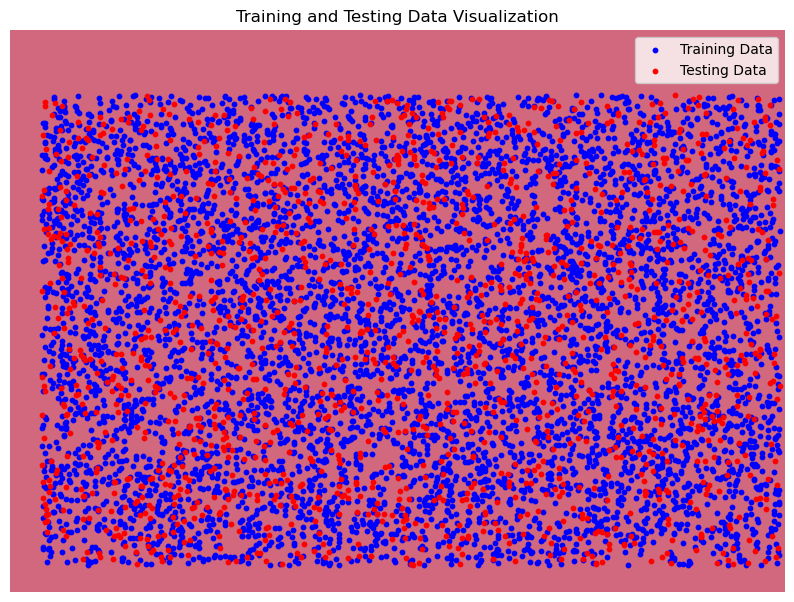

In [46]:
# Create a copy of the ground truth for visualizing purposes
gt_vis = np.copy(gt)

# Assign the training data a specific value (e.g., 1)
gt_vis[train_rows, train_cols] = 1

# Assign the testing data a different value (e.g., 2)
gt_vis[test_rows, test_cols] = 2

# Plot the ground truth with different colors for training and testing
plt.figure(figsize=(10, 10))

# Plot the training data in one color (e.g., blue)
plt.imshow(gt_vis, cmap='coolwarm', alpha=0.6)

# Overlay training data points as circles (with label for training)
plt.scatter(train_cols, train_rows, color='blue', marker='o', label="Training Data", s=10)

# Overlay testing data points as squares (with label for testing)
plt.scatter(test_cols, test_rows, color='red', marker='o', label="Testing Data", s=10)

# Add title and legend
plt.title("Training and Testing Data Visualization")
plt.legend()

plt.axis("off")  # Hide the axes for better visualization
plt.show()


## Dimensionality reduction: Case 1
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). It helps in reducing the spectral dimension significantly without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [47]:
# data_set_1 = util.reduce_dim(img_data=data_set, n_components=0.98)
# # Normalize data to ensure consistent feature scaling
# data_set_1 = util.rescale_data(data_set_1)
# data_set_1.shape

data_set_1=data_set

## Dimensionality reduction: Case 2

In [48]:
# data_set_2 = util.reduce_dim(img_data=data_set, n_components=0.99)
# # Normalize data to ensure consistent feature scaling
# data_set_2 = util.rescale_data(data_set_2)
# data_set_2.shape

## Dimensionality reduction: Case 3

In [49]:
# data_set_3 = util.reduce_dim(img_data=data_set, n_components=0.999)
# # Normalize data to ensure consistent feature scaling
# data_set_3 = util.rescale_data(data_set_3)
# data_set_3.shape

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models. 
In this notebook, a 2-D CNN model with a 'path_size' of 5 is used for classification.  

In [50]:
patch_size=5
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

def create_train_patch(data_set):
    train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)
    return train_input_sub, y_train_sub
    

def create_val_patch(data_set):
    val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)
    return val_input, y_val


def create_test_patch(data_set):
    test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)
    return test_input, y_test


In [51]:
#case_1
train_input_sub_1, y_train_sub_1 = create_train_patch(data_set_1)
val_input_1, y_val_1 = create_val_patch(data_set_1)
test_input_1, y_test_1 = create_test_patch(data_set_1)

# #case_2
# train_input_sub_2, y_train_sub_2 = create_train_patch(data_set_2)
# val_input_2, y_val_2 = create_val_patch(data_set_2)
# test_input_2, y_test_2 = create_test_patch(data_set_2)

# #case_3
# train_input_sub_3, y_train_sub_3 = create_train_patch(data_set_3)
# val_input_3, y_val_3 = create_val_patch(data_set_3)
# test_input_3, y_test_3 = create_test_patch(data_set_3)

In [52]:
# train_input_sub_1[0]



## Creating a LSTM model
The network architecture consists of a 2-D convolutional layer as input layer. The input layer is followed by a maximum pooling layer with a pooling and stride size of 2. The third layer is a another 2-D convolutional layer, followed by a maximum pooling layer. The fifth layer flattens the outputs of the forth layer and pass them to a 'drop out' layer with a drop rate of 0.35. The 'drop out' layer is followed by three 'dense' layers with the last one as the output layer.

In [53]:
l2_parm = 1e-3
units_1 = 2**10
units_2 =2**9
units_3=2**8
units_4=2**7
drop_rate = 0.2#0.35
num_catg = len(catg_labels)  # Number of categories

def create_lstm_model(input_shape):
    # For LSTM, we need to treat the spectral bands as time steps
    time_steps = input_shape[2]  # Number of spectral bands
    features = input_shape[0] * input_shape[1]  # Flatten height and width into features for LSTM
    # Building an LSTM model
    lstm_model = models.Sequential()

    # Reshape the input data for LSTM
    lstm_model.add(layers.Reshape((time_steps, features), input_shape=input_shape))
    lstm_model.add(layers.LSTM(units=units_4, return_sequences=True,kernel_regularizer=regularizers.l2(l2_parm)))

    # Add more LSTM layers or Dense layers if required
    # lstm_model.add(layers.LSTM(units=units_4, return_sequences=True, kernel_regularizer=regularizers.l2(l2_parm)))

    # Add more LSTM layers or Dense layers if required
    lstm_model.add(layers.LSTM(units=units_4, return_sequences=True))

    # Add more LSTM layers or Dense layers if required
    lstm_model.add(layers.LSTM(units=units_4, return_sequences=False))

    lstm_model.add(layer=layers.Flatten())
    lstm_model.add(layers.Dropout(drop_rate))

    # dense_1
    lstm_model.add(layer=layers.Dense(units=units_2, activation='relu'))
    lstm_model.add(layers.BatchNormalization())

    lstm_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))
    # print(train_input_sub_1.shape)
    lstm_model.summary()
    return lstm_model


## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors) 

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Can use 'val_accuracy' if preferred
    patience=5,            # Stop training after 5 epochs of no improvement
    restore_best_weights=True,  # Restore the best weights from the epoch with the lowest validation loss
    verbose=1              # Print messages when early stopping is triggered
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

lr = 1e-5
batch_size = 2**6
input_shape_1 = train_input_sub_1.shape[1:]  # Shape of the input data (height, width, channels)
# input_shape_2 = train_input_sub_2.shape[1:]  # Shape of the input data (height, width, channels)
# input_shape_3 = train_input_sub_3.shape[1:]  # Shape of the input data (height, width, channels)

lstm_model_1=create_lstm_model(input_shape_1)
# Compiling the model
lstm_model_1.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])

# lstm_model_2=create_lstm_model(input_shape_2)
# # Compiling the model
# lstm_model_2.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
#                  loss=losses.categorical_crossentropy,
#                  metrics=[metrics.categorical_accuracy])

# lstm_model_3=create_lstm_model(input_shape_3)
# # Compiling the model
# lstm_model_3.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
#                  loss=losses.categorical_crossentropy,
#                  metrics=[metrics.categorical_accuracy])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 4, 25)             0         
                                                                 
 lstm_3 (LSTM)               (None, 4, 128)            78848     
                                                                 
 lstm_4 (LSTM)               (None, 4, 128)            131584    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [55]:
print("*****Fitting LSTM Model 1******")

history_case_1 = lstm_model_1.fit(x=train_input_sub_1, y=y_train_sub_1, batch_size=batch_size,
                        epochs=100, validation_data=(val_input_1, y_val_1), verbose=False, callbacks=[early_stopping,reduce_lr])
# print("*****Fitting LSTM Model 2******")
# history_case_2 = lstm_model_2.fit(x=train_input_sub_2, y=y_train_sub_2, batch_size=batch_size,
#                     epochs=50, validation_data=(val_input_2, y_val_2), verbose=False, callbacks=[early_stopping,reduce_lr])
# print("*****Fitting LSTM Model 3******")
# history_case_3 = lstm_model_3.fit(x=train_input_sub_3, y=y_train_sub_3, batch_size=batch_size,
#                     epochs=50, validation_data=(val_input_3, y_val_3), verbose=False, callbacks=[early_stopping,reduce_lr])



*****Fitting LSTM Model 1******
Restoring model weights from the end of the best epoch: 29.
Epoch 34: early stopping


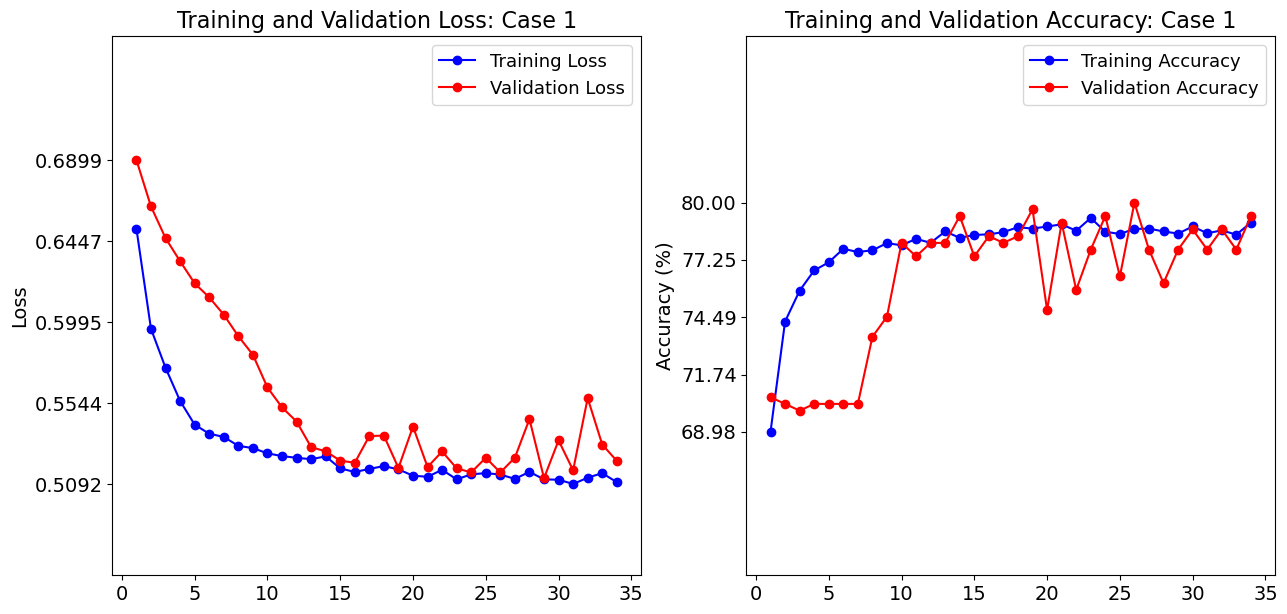

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot history
def plot_history(history, subtitle):
    epoches = np.arange(1, len(history.history.get('loss')) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 7))  # Removed sharey=True

    # Extract Loss Values
    train_loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    # Extract Accuracy Values (Scaled to Percentage)
    train_acc = [x * 100 for x in history.history.get('categorical_accuracy')]
    val_acc = [x * 100 for x in history.history.get('val_categorical_accuracy')]

    # --- Plot Training & Validation Loss ---
    ax1.plot(epoches, train_loss, 'b', marker='o', label='Training Loss')
    ax1.plot(epoches, val_loss, 'r', marker='o', label='Validation Loss')
    ax1.set_title('Training and Validation Loss: ' + subtitle, fontsize=16)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=13)
    ax1.tick_params(axis='x', labelsize=14)  
    ax1.tick_params(axis='y', labelsize=14)
    
    # Dynamically adjust the Y-Axis range for loss
    ax1.set_ylim(min(train_loss + val_loss) * 0.9, max(train_loss + val_loss) * 1.1)
    ax1.set_yticks(np.linspace(min(train_loss + val_loss), max(train_loss + val_loss), num=5))  # 5 evenly spaced ticks

    # --- Plot Training & Validation Accuracy ---
    ax2.plot(epoches, train_acc, 'b', marker='o', label='Training Accuracy')
    ax2.plot(epoches, val_acc, 'r', marker='o', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy: ' + subtitle, fontsize=16)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)  # Accuracy in Percentage
    ax2.legend(fontsize=13)
    ax2.tick_params(axis='x', labelsize=14)  
    ax2.tick_params(axis='y', labelsize=14)

    # Dynamically adjust the Y-Axis range for accuracy
    ax2.set_ylim(min(train_acc + val_acc) * 0.9, max(train_acc + val_acc) * 1.1)
    ax2.set_yticks(np.linspace(min(train_acc + val_acc), max(train_acc + val_acc), num=5))  # 5 evenly spaced ticks

    plt.show()

plot_history(history_case_1,"Case 1")
# plot_history(history_case_2, "Case 2")
# plot_history(history_case_3, "Case 3")


## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [57]:
def evaluate_model(lstm_model, test_input, y_test, subtitle):
    overall_loss, overal_accu = lstm_model.evaluate(test_input, y_test, verbose=False)
    print(f'{subtitle}')
    print('Overall loss = {}'.format(overall_loss))
    print('Overall accuracy = {}\n'.format(overal_accu))

    # uncomment following for calculating and printing accuracy per class
    # model_metrics = util.calc_metrics(lstm_model, test_input,
    #                                         y_test, int_to_vector_dict, verbose=False)
    
    # print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
    # for key, val in model_metrics.items():
    #     print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))


evaluate_model(lstm_model_1,test_input_1, y_test_1, "Case 1")
# evaluate_model(lstm_model_2,test_input_2, y_test_2, "Case 2")
# evaluate_model(lstm_model_3,test_input_3, y_test_3,"Case 3")

Case 1
Overall loss = 0.5198696255683899
Overall accuracy = 0.7851132750511169



In [58]:
#save model
lstm_model_1.save(output_model_path)  # Saves in HDF5 format

## Making predictions using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels. 

In [59]:
import matplotlib.colors as mcolors
def make_prediction(lstm_model,data_set,train_input_sub, val_input, test_input,y_train_sub, y_val, y_test):
    # Plotting predicted results
    concat_rows =  np.concatenate((train_rows_sub, val_rows, test_rows))
    concat_cols = np.concatenate((train_cols_sub, val_cols, test_cols))
    concat_input = np.concatenate((train_input_sub, val_input, test_input))
    concat_y = np.concatenate((y_train_sub, y_val, y_test))
    pixel_indices = (concat_rows, concat_cols)

    partial_map = util.plot_partial_map(lstm_model, gt, pixel_indices, concat_input,
                                concat_y, int_to_vector_dict, plo=False)
    full_map,legend = util.plot_full_map(lstm_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)

    return partial_map, full_map, legend

def plot_and_save_result(partial_map, full_map, unique_classes, subtitle):

    print(np.unique(partial_map))
    print(np.unique(full_map))
    print(unique_classes.keys())

    handles = []
    labels = []
    cmap = plt.get_cmap('tab20')  # You can change the colormap if you prefer tab10
    colors = [cmap(i / len(unique_classes)) for i in range(len(unique_classes))]
    for i, class_label in enumerate(unique_classes):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10))
        labels.append(classes[class_label])
    fixed_cmap = mcolors.ListedColormap(colors)  # Fixed colormap
    norm = mcolors.BoundaryNorm(list(unique_classes.keys()) + [max(unique_classes) + 1], fixed_cmap.N)  # Normalize class values

    
    fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, sharey=True, figsize=(15,7))
    ax1.imshow(partial_map,cmap=fixed_cmap,norm=norm,interpolation="nearest")
    ax1.set_title(f'Prediction map for labeled data: {subtitle}', fontweight="bold", fontsize='14')
    ax1.legend(handles=handles, labels=labels, loc='lower right', title="Classes",fontsize="x-small")

    ax2.imshow(full_map, cmap=fixed_cmap,norm=norm, interpolation="nearest")
    ax2.set_title(f'Prediction map for all data: {subtitle}', fontweight="bold", fontsize='14')
    # ax2.legend(handles=handles, labels=labels, loc='lower right', title="Classes",fontsize="x-small")
    ax2.set_title(f"Prediction map for all data: {subtitle}", fontweight="bold", fontsize=14)
    plt.show()

    # Save the output classified image
    full_map_tiff = full_map.astype(np.uint8)  #int is not supported
    # Example values: Replace with your actual georeference information
    transform = from_origin(0, 145, 1, 1)  # (top-left x, top-left y, pixel width, pixel height)

    # Save full_map as a .tif file
    with rasterio.open(
        f'output/classified_MAP_LSTM_{subtitle}.tif',
        'w',
        driver='GTiff',
        height=full_map_tiff.shape[0],
        width=full_map_tiff.shape[1],
        count=1,  # Number of bands
        dtype=full_map_tiff.dtype,
        crs='EPSG:32633',  # Coordinate reference system (adjust as needed)
        transform=transform,
    ) as dst:
        dst.write(full_map_tiff, 1)

In [60]:
partial_map_1, full_map_1, unique_classes_1 = make_prediction(lstm_model_1,data_set_1,train_input_sub_1, val_input_1, test_input_1, y_train_sub_1, y_val_1, y_test_1)
# partial_map_2, full_map_2, unique_classes_2 = make_prediction(lstm_model_2,data_set_2,train_input_sub_2, val_input_2, test_input_2, y_train_sub_2, y_val_2, y_test_2)
# partial_map_3, full_map_3, unique_classes_3 = make_prediction(lstm_model_3,data_set_3,train_input_sub_3, val_input_3, test_input_3, y_train_sub_3, y_val_3, y_test_3)

 107369/2186883 [>.............................] - ETA: 2:16:33

KeyboardInterrupt: 

In [ ]:
plot_and_save_result(partial_map_1, full_map_1, unique_classes_1,'Case 1 (PCA 15)')
# plot_and_save_result(partial_map_2, full_map_2, unique_classes_2,'Case 2 (PCA 25)')
# plot_and_save_result(partial_map_3, full_map_3, unique_classes_3,'Case 3 (PCA 69)')

Legend is valid for corresponding prediction map as well.

The salt-and-pepper noise is more in case 1 and case 3. 